# Sigma Risk | Conditional Value at Risk Optimisation

### Data Scraping and Defining Functions

In [3]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as dr 
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm

In [4]:
rf = 0.0156 #Check yield of 10 year US TBill
min_weight = 0.025
max_weight = 1
max_risk_contribution = 0.1

# Monte carlo -> for comparison to the optimal portfolio
number_of_portfolios = 50000

In [5]:
# Initialize Input Data
start_date = '2018-01-01'
today = datetime.today().strftime('%Y-%m-%d')
assets = pd.read_excel ('SigmaInput.xlsx')["Ticker"]

# Create df for adjusted close prices of portfolio
prices = pd.DataFrame()

for stock in assets:
    prices[stock] = dr.data.get_data_yahoo(stock, start =start_date, end =today)['Adj Close']

#Show the daily simple return
return_stocks = (prices/prices.shift(1))-1
#return_stocks.to_excel('PortfolioReturns.xlsx')

In [6]:
cov_matrix = return_stocks.cov()*252 
cov_matrix_np = cov_matrix.to_numpy()
equally_weighted = [1/len(assets),]*len(assets)

In [7]:
# function to obtain portfolio- return,volatility,sharpe.
def get_p_data(weights):
        weights = np.array(weights)
        p_return= np.sum(return_stocks.mean()*weights) * 252
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(return_stocks.cov()*252, weights)))
        p_sharpe = (p_return-rf)/p_volatility 
        p_CVaR5 = (5/100)**-1 * norm.pdf(norm.ppf(5/100))*p_volatility - p_return
        p_VaR5 = norm.ppf(0.05, loc=p_return, scale=p_volatility)
        return np.array([p_return, p_volatility, p_sharpe, p_CVaR5, p_VaR5])

def get_p_volatility(weights):
        weights = np.array(weights)
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(return_stocks.cov()*252, weights)))
        return p_volatility

In [8]:
# function to get the marginal volatilities 
def marginal_volatilities(weights, cov_matrix_np):
    volatility_p = get_p_volatility(weights)
    print("portfolio volatility = ", volatility_p )
        
    for i in range(len(weights)):
        cov_weight_i = (weights[i] * np.dot(cov_matrix_np, weights)[i])/volatility_p 
        print("i = ", i , "risk contribution = ", cov_weight_i)

In [9]:
# args is defined as the tuple of arguments with first the max risk contribution and then the covariance matrix
def risk_budget(weights, i, *args):
    volatility_p = get_p_volatility(weights)
    dot_product = np.dot(args[1], weights)
    dot_product_value = np.take(dot_product, i)
    q = args[0]*volatility_p - (weights[i]*dot_product_value/volatility_p)
    return q

In [10]:
# function to get negative Sharpe Ratio.
def CVaR(weights):
        return get_p_data(weights)[3]
    
def VaR(weights):
        return get_p_data(weights)[4]

# function to check if sum investment is 1.
def check_sum(weights):
        return np.sum(weights) -1

# constraint for objective function-np
constraints_list = list()

#  sum investment is 1
constraints_list.append({'type':'eq', 'fun':check_sum})

# individual risk constributions
a = list(range(len(assets)))
for i in a:
    constraints_list.append({'type':'ineq', 'fun': risk_budget, 'args':(i, max_risk_contribution, cov_matrix_np)})  

constraints = tuple(constraints_list)

# weight boundaries
bounds = ((min_weight,max_weight),)*len(assets)

# equally weighted portfolio / starting point of Sequantial least Squares programming method.
equally_weighted = [1/len(assets),]*len(assets)

### Generating Random Portfolio's

In [11]:
# Initialization of arrays we will use for n number of random portfolios. 
portfolio_returns = []
portfolio_sd = []
portfolio_sharpe = []
portfolio_weights = []
portfolio_CVaR = []
portfolio_VaR = []

# Create n number of portfolios with random weights allocations and perform calculations for portfolio data. 
for portfolio in range (number_of_portfolios):
    
    # Generate random weights vector with lengts of number of assets
    weights = weights = max_weight * np.random.random_sample((len(assets))) + min_weight
    weights = weights / np.sum(weights)
  
    # Calculate Annual Return of random portfolios
    annual_return = np.sum((return_stocks.mean() * weights) * 252)
    portfolio_returns.append(annual_return)
  
    # Calculate Covariance Matrix for assets in random portfolios
    cov_matrix_portfolio = (return_stocks.cov()) * 252
  
    # Calculate Volatility/SD of random portfolios
    portfolio_variance = np.dot(weights.T,np.dot(cov_matrix_portfolio, weights))
    portfolio_standard_deviation = np.sqrt(portfolio_variance) 
    portfolio_sd.append(portfolio_standard_deviation)
  
    # Calculate Sharpe's of random portfolios
    sharpe_ratio = ((annual_return - rf)/portfolio_standard_deviation)
    portfolio_sharpe.append(sharpe_ratio)
  
    # Calculate CVaRs of random portfolios for alpha = 0.05
    portfolio_CVaR5 = (5/100)**-1 * norm.pdf(norm.ppf(5/100))*portfolio_standard_deviation - annual_return
    portfolio_CVaR.append(portfolio_CVaR5)
    
    # Calculate VaRs of random portfolios for alpha = 0.05
    portfolio_VaR5 = norm.ppf(5/100,annual_return,portfolio_standard_deviation)
    portfolio_VaR.append(portfolio_VaR5)
    
    # Add random portfolio weights to weight array of portfolios.
    portfolio_weights.append(weights)

# Turn portfolio arrays into numpy arrays. 
portfolio_weights = np.array(portfolio_weights)
portfolio_sd = np.array(portfolio_sd)
portfolio_returns = np.array(portfolio_returns)
portfolio_sharpe = np.array(portfolio_sharpe)
portfolio_CVaR = np.array(portfolio_CVaR)
portfolio_VaR = np.array(portfolio_VaR)

### Plotting CVaR and Returns of Random Portfolio's

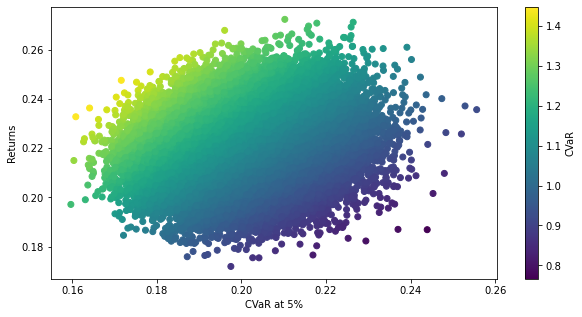

In [12]:
# Plot Return vs CVaR5
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_CVaR, portfolio_returns, c=portfolio_returns / portfolio_CVaR)
plt.xlabel('CVaR at 5%')
plt.ylabel('Returns')
plt.colorbar(label='CVaR')

### Creating Table Containing Portfolio's with Lowest CVaR

In [13]:
#Converting Array of weights into List
portfolio_weights_list = portfolio_weights.tolist()

In [14]:
#Creating DataFrame with all needed values
data = {'CVaR':np.round(portfolio_CVaR,4),'Return':np.round(portfolio_returns,4),'Sharpe':np.round(portfolio_sharpe,4)}
df = pd.DataFrame(data)
print(df)

#Creating Ugly DataFrame with Weights
data2 = {'CVaR':np.round(portfolio_CVaR,4),'Return':np.round(portfolio_returns,4),'Sharpe':np.round(portfolio_sharpe,4),'Weights':portfolio_weights_list}
df2 = pd.DataFrame(data2)

         CVaR  Return  Sharpe
0      0.2097  0.2054  0.9432
1      0.1942  0.2202  1.0185
2      0.2106  0.2045  0.9386
3      0.1839  0.2287  1.0653
4      0.1732  0.2233  1.0805
...       ...     ...     ...
49995  0.2146  0.2445  1.0285
49996  0.1965  0.2367  1.0529
49997  0.1922  0.2215  1.0266
49998  0.1964  0.1927  0.9387
49999  0.2143  0.2332  1.0030

[50000 rows x 3 columns]


In [15]:
#Sorting DataFrame w.r.t CVaR Lowest to Highest, n lowest CVaR values
def create_top (n):
    return df.CVaR.sort_values().head(n)

In [16]:
#Function which prints table for given portfolio
def top_5 (a,b,c,d,e):
    top_5_table = pd.concat([df.iloc[a],df.iloc[b],df.iloc[c],df.iloc[d],df.iloc[e]],axis = 1).T
    print (top_5_table)

In [17]:
create_top(5)

46059    0.1596
38699    0.1604
369      0.1608
19881    0.1626
43093    0.1629
Name: CVaR, dtype: float64

### Create table with Results from create_top(5)

In [18]:
top_5(46059, 38699, 369, 19881, 43093)

         CVaR  Return  Sharpe
46059  0.1596  0.1972  1.0496
38699  0.1604  0.2150  1.0958
369    0.1608  0.2328  1.1383
19881  0.1626  0.2226  1.1084
43093  0.1629  0.2239  1.1110


In [19]:
#Function which prints weights of given portfolio
def print_weights(index):
    print(np.round(df2.loc[index,'Weights'],4))

In [20]:
print_weights(46059)

[0.0584 0.1045 0.0178 0.0183 0.0241 0.0254 0.0049 0.0475 0.0425 0.011
 0.0297 0.0061 0.0701 0.0836 0.1011 0.0967 0.0495 0.0158 0.1125 0.0347
 0.046 ]


In [21]:
# Plot Return vs CVaR5 - 5 Lowest CVaR Portfolio's Highlighted
def plot_top5(a,b,c,d,e):
    plt.figure(figsize=(10, 5))
    plt.scatter(portfolio_CVaR, portfolio_returns, c=portfolio_returns / portfolio_CVaR)
    
    plt.scatter(df.loc[a,'CVaR'], df.loc[a,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[b,'CVaR'], df.loc[b,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[c,'CVaR'], df.loc[c,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[d,'CVaR'], df.loc[d,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[e,'CVaR'], df.loc[e,'Return'], s=150, c='orange', marker=(3, 1))
    
    plt.xlabel('CVaR at 5%')
    plt.ylabel('Returns')
    plt.colorbar(label='CVaR')

### Highlight Lowest CVaR Portfolio's

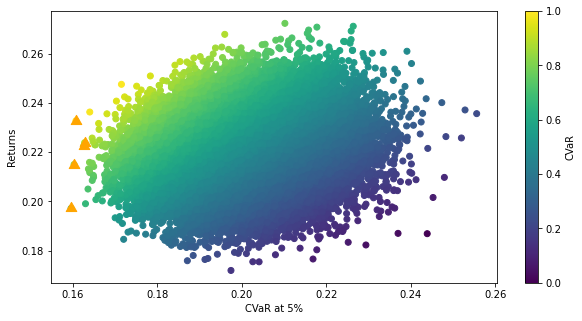

In [22]:
plot_top5(46059, 38699, 369, 19881, 43093)

### CVaR Optimisation

In [23]:
#CVaR Optimisation
optimal_result_CVaR = minimize(CVaR, equally_weighted, method='SLSQP', bounds=bounds, constraints = constraints)
optimal_weights_CVaR = optimal_result_CVaR.x
optimal_portfolio_CVaR = get_p_data(optimal_result_CVaR.x)

optimal_return_CVaR = np.round(optimal_portfolio_CVaR[0],4)
optimal_volatility_CVaR = np.round(optimal_portfolio_CVaR[1],4)
optimal_sharpe_CVaR = np.round(optimal_portfolio_CVaR[2],4)
min_CVaR = np.round(optimal_portfolio_CVaR[3],4)
overview_CVaR = pd.DataFrame({'Assets': assets,'Weight (%)': np.round(optimal_weights_CVaR*100,2)}, columns=['Assets', 'Weight (%)']).T

statistic_CVaR = ['Number of Assets', 'Expected Return', 'Expected Volatility', 'Expected Sharpe', 'Expected CVaR']
data_CVaR = [np.round(len(assets),1), optimal_return_CVaR, optimal_volatility_CVaR, optimal_sharpe_CVaR, min_CVaR]
table_CVaR = pd.DataFrame(data_CVaR, statistic_CVaR)

In [24]:
#Overview CVaR Optimisation
print(overview_CVaR)
overview_CVaR.to_excel('minCVaR_Optimisation.xlsx')
print(table_CVaR)

                0      1    2    3       4    5     6    7      8    9   ...  \
Assets      HEN.DE  AD.AS  DHI   MA  ALV.DE  JPM  EQIX  MDT    NVO  UNH  ...   
Weight (%)     2.5  17.74  2.5  2.5     2.5  2.5   2.5  2.5  10.66  2.5  ...   

             11    12       13      14    15   16    17       18   19    20  
Assets      MGA    WM  EOAN.DE  DTE.DE  NFLX  ETN  NVDA  PHIA.AS  SAP  ICLN  
Weight (%)  2.5  8.54     6.84    7.44  7.53  2.5   2.5     6.25  2.5   2.5  

[2 rows x 21 columns]
                           0
Number of Assets     21.0000
Expected Return       0.2009
Expected Volatility   0.1680
Expected Sharpe       1.1029
Expected CVaR         0.1456


### Plot Min CVaR Portfolio and 5 Lowest CVaR Portfolios

In [25]:
# Plot Return vs CVaR5
def plot_top5_optimal(a,b,c,d,e):
    plt.figure(figsize=(10, 5))
    plt.scatter(portfolio_CVaR, portfolio_returns, c=portfolio_returns / portfolio_CVaR)
    plt.scatter(min_CVaR, optimal_return_CVaR, s=200, c='red', marker=(5, 1))
    
    plt.scatter(df.loc[a,'CVaR'], df.loc[a,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[b,'CVaR'], df.loc[b,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[c,'CVaR'], df.loc[c,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[d,'CVaR'], df.loc[d,'Return'], s=150, c='orange', marker=(3, 1))
    plt.scatter(df.loc[e,'CVaR'], df.loc[e,'Return'], s=150, c='orange', marker=(3, 1))
    
    plt.xlabel('CVaR at 5%')
    plt.ylabel('Returns')
    plt.colorbar(label='CVaR')

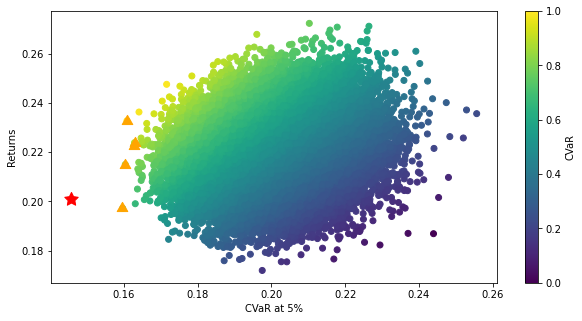

In [27]:
plot_top5_optimal(46059, 38699, 369, 19881, 43093)

### VaR Optimisation

In [271]:
#VaR Optimisation
optimal_result_VaR = minimize(VaR, equally_weighted, method='SLSQP', bounds=bounds, constraints = constraints)
optimal_weights_VaR = optimal_result_VaR.x
optimal_portfolio_VaR = get_p_data(optimal_result_VaR.x)

optimal_return_VaR = np.round(optimal_portfolio_VaR[0],2)
optimal_volatility_VaR = np.round(optimal_portfolio_VaR[1],2)
optimal_sharpe_VaR = np.round(optimal_portfolio_VaR[2],2)
min_VaR = np.round(optimal_portfolio_VaR[4],2)
overview_VaR = pd.DataFrame({'Assets': assets,'Weight (%)': np.round(optimal_weights_VaR*100,2)}, columns=['Assets', 'Weight (%)']).T

statistic_VaR = ['Number of Assets', 'Expected Return', 'Expected Volatility', 'Expected Sharpe', 'Expected VaR']
data_VaR = [np.round(len(assets),0), optimal_return_VaR, optimal_volatility_VaR, optimal_sharpe_VaR, min_VaR]
table_VaR = pd.DataFrame(data_VaR, statistic_VaR)

In [ ]:
#Overview VaR Optimisation
print(overview_VaR)
overview_VaR.to_excel('minVaR_Optimisation.xlsx')
print(table_VaR)